<font color=gray size=5> Import Necessary Libraries </font>

In [1]:
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

<font color=gray size=5> Make Image (400,300,3) </font>

In [2]:
img = Image.open("images/style.jpg")
resized = img.resize((400,300))
resized.save("images/style_in.jpg")

img = Image.open("images/content.jpg")
resized = img.resize((400,300))
resized.save("images/content_in.jpg")

<font color=gray size=5> Input Image Size </font>

In [3]:
height,width = 300,400                                              

<font color=gray size=5> RGB Mean </font>

In [4]:
means=np.array([123.68,116.779,103.939]).reshape((1,1,1,3))  

<font color=gray size=5> Construct VGG_19 </font>

In [5]:
def load_vgg19(path):
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weight(layer_id,layer_name):
        params = vgg_layers[0][layer_id][0][0][2]
        W = params[0][0]
        b = params[0][1]
        assert layer_name == vgg_layers[0][layer_id][0][0][0][0]
        return W,b
    def _relu(prev_layer):
        return tf.nn.relu(prev_layer)
    def _conv2D(prev_layer,layer_id,layer_name):
        W,b = _weight(layer_id,layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b,(b.size)))
        return tf.nn.conv2d(prev_layer,filter=W,strides=[1,1,1,1],padding='SAME')+b
    def _conv2d_relu(prev_layer, layer_id, layer_name):
        return _relu(_conv2D(prev_layer,layer_id,layer_name))
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
    Model={}
    
    Model['input'] = tf.Variable(np.zeros((1,height,width,3)), dtype = 'float32')#
    
    Model['conv1_1'] = _conv2d_relu(Model['input'],0,'conv1_1')#0,1
    Model['conv1_2'] = _conv2d_relu(Model['conv1_1'],2,'conv1_2')#2,3
    
    Model['avgpool1'] = _avgpool(Model['conv1_2'])#4
    
    Model['conv2_1'] = _conv2d_relu(Model['avgpool1'],5,'conv2_1')#5,6
    Model['conv2_2'] = _conv2d_relu(Model['conv2_1'],7,'conv2_2')#7,8
    
    Model['avgpool2'] = _avgpool(Model['conv2_2'])#9
    
    Model['conv3_1'] = _conv2d_relu(Model['avgpool2'],10,'conv3_1')#10,11
    Model['conv3_2'] = _conv2d_relu(Model['conv3_1'],12,'conv3_2')#12,13
    Model['conv3_3'] = _conv2d_relu(Model['conv3_2'],14,'conv3_3')#14,15
    Model['conv3_4'] = _conv2d_relu(Model['conv3_3'],16,'conv3_4')#16,17
    
    Model['avgpool3'] = _avgpool(Model['conv3_4'])#18
    
    Model['conv4_1'] = _conv2d_relu(Model['avgpool3'],19,'conv4_1')#19,20
    Model['conv4_2'] = _conv2d_relu(Model['conv4_1'],21,'conv4_2')#21,22
    Model['conv4_3'] = _conv2d_relu(Model['conv4_2'],23,'conv4_3')#23,24
    Model['conv4_4'] = _conv2d_relu(Model['conv4_3'],25,'conv4_4')#25,26
    
    Model['avgpool4'] = _avgpool(Model['conv4_4'])#27
    
    Model['conv5_1'] = _conv2d_relu(Model['avgpool4'],28,'conv5_1')#28,29
    Model['conv5_2'] = _conv2d_relu(Model['conv5_1'],30,'conv5_2')#30,31
    Model['conv5_3'] = _conv2d_relu(Model['conv5_2'],32,'conv5_3')#32,33
    Model['conv5_4'] = _conv2d_relu(Model['conv5_3'],34,'conv5_4')#34,35
    
    Model['avgpool5'] = _avgpool(Model['conv5_4'])#36
    
    return Model
    
    

<font color=gray size=5> 
VGG_19 Architecture:<br><br>
0 : conv1_1 (3, 3, 3, 64)       1 : relu<br>
2 : conv1_2 (3, 3, 64, 64)      3 : relu    
4 : maxpool<br>
5 : conv2_1 (3, 3, 64, 128)     6 : relu<br>
7 : conv2_2 (3, 3, 128, 128)    8 : relu<br>
9 : maxpool<br>
10: conv3_1 (3, 3, 128, 256)    11: relu<br>
12: conv3_2 (3, 3, 256, 256)    13: relu<br>
14: conv3_3 (3, 3, 256, 256)    15: relu<br>
16: conv3_4 (3, 3, 256, 256)    17: relu<br>
18: maxpool<br>
19: conv4_1 (3, 3, 256, 512)    20: relu<br>
21: conv4_2 (3, 3, 512, 512)    22: relu<br>
23: conv4_3 (3, 3, 512, 512)    24: relu<br>
25: conv4_4 (3, 3, 512, 512)    26: relu<br>
27: maxpool<br>
28: conv5_1 (3, 3, 512, 512)    29: relu<br>
30: conv5_2 (3, 3, 512, 512)    31: relu<br>
32: conv5_3 (3, 3, 512, 512)    33: relu<br>
34: conv5_4 (3, 3, 512, 512)    35: relu<br>
36: maxpool<br>
37: fullyconnected (7, 7, 512, 4096)    38: relu<br>
39: fullyconnected (1, 1, 4096, 4096)   40: relu<br>
41: fullyconnected (1, 1, 4096, 1000)
42: softmax<br>
</font>

<font color=gray size=5> Load Pretrained Weight & Bias </font>

In [6]:
vgg=scipy.io.loadmat("imagenet-vgg-verydeep-19-e.mat")
print vgg.keys()
vgg_layers=vgg['layers']
print np.shape(vgg_layers)

['layers', '__version__', 'meta', '__header__', '__globals__']
(1, 43)


In [7]:
print np.shape(vgg['layers'][0])
print vgg['layers'][0][0][0][0][0][0]
print np.shape(vgg['layers'][0][0])
print np.shape(vgg['layers'][0][0][0][0])
print np.shape(vgg['layers'][0][0][0][0][2])
print vgg['layers'][0][0][0][0][2][0][1].shape

(43,)
conv1_1
(1, 1)
()
(1, 2)
(64, 1)


<font color=gray size=5> Get VGG_19 </font>

In [8]:
model = load_vgg19("imagenet-vgg-verydeep-19-e.mat")
model

{'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 

<font color=gray size=5>Define content cost</font>

In [9]:
def J_content(a_C,a_G):
    a_shape=a_G.get_shape().as_list()
    m,n_H,n_W,n_C=a_shape
    a_C_reshape = tf.reshape(a_C,[n_H*n_W,n_C])
    a_G_reshape = tf.reshape(a_G,[n_H*n_W,n_C])
    J_GC=tf.reduce_sum(tf.square(tf.subtract(a_C_reshape,a_G_reshape)))/(4.*n_H*n_W*n_C)
    return J_GC

<font color=gray size=5>Define single layer style cost</font>

In [10]:
def J_style_layer(a_S,a_G):
    a_shape=a_G.get_shape().as_list()
    m,n_H,n_W,n_C=a_shape
    a_S2 = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G2 = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    #Create Gram Matrix For Style Estimate
    cov_a_S2 = tf.matmul(a_S2,tf.transpose(a_S2))
    cov_a_G2 = tf.matmul(a_G2,tf.transpose(a_G2))
    J_SG = tf.reduce_sum(tf.square(tf.subtract(cov_a_S2,cov_a_G2)))/(4*n_H**2*n_W**2*n_C**2)
    return J_SG

In [11]:
layer_coefs = [('conv1_1', 0.2),('conv2_1', 0.2),('conv3_1', 0.2),('conv4_1', 0.2),('conv5_1', 0.2)]

<font color=gray size=5>Define style cost</font>

In [12]:
def J_style(model,layers_coefs):
    J_SG = 0
    for layer_name,coef in layer_coefs:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_layer = J_style_layer(a_S,a_G)
        J_SG += J_layer*coef
    return J_SG

<font color=gray size=5> Load 3 Images</font>

In [13]:
def reshape_normalize(im):
    #VGG input shape (1,height,width,channels)
    im=np.reshape(im, ((1,) + im.shape))
    return im-means

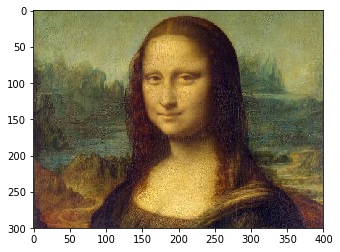

In [14]:
content_image = scipy.misc.imread("images/content_in.jpg")
imshow(content_image)
content_image = reshape_normalize(content_image)


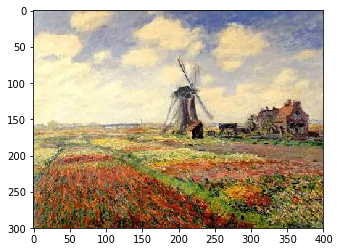

In [15]:
style_image = scipy.misc.imread("images/style_in.jpg")
imshow(style_image)
style_image = reshape_normalize(style_image)

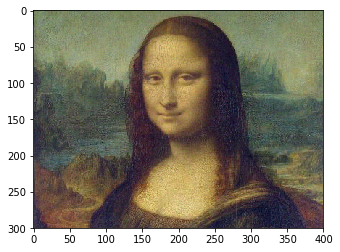

In [16]:
#Initialize Generated Image
def noise_im(im_content,ratio=0.3):
    im_noise=np.random.uniform(-20,20,(1,height,width,3)).astype('float32')
    return im_noise*ratio+im_content*(1-ratio)
generated_image = noise_im(content_image)
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
test=normalize(generated_image)
imshow(test[0,:,:,:])

<font color=gray size=5> Interactive Session Start</font>

In [17]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#Set Graph
model = load_vgg19("imagenet-vgg-verydeep-19-e.mat")


<font color=gray size=5>Feed content to get constant a_C</font>

In [18]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

<font color=gray size=5>Set Tensor a_G</font>

In [19]:
# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

<font color=gray size=5>Compute content cost(Tesor a_G & Constant a_C)</font>

In [20]:
# Compute the content cost
J_CG = J_content(a_C, a_G)

<font color=gray size=5>Compute style cost(Tesor a_G & 5 Constant a_Ss)</font>

In [21]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_SG = J_style(model, layer_coefs)

<font color=gray size=5>Compute the total cost</font>

In [22]:
#Tune alpha,beta to define total cost
alpha,beta = 1,1000
J = alpha*J_CG+beta*J_SG

<font color=gray size=5>Define train step</font>

In [23]:
train_step=tf.train.AdamOptimizer(2.0).minimize(J)

<font color=gray size=5>Initialize global variables</font>

In [24]:
sess.run(tf.global_variables_initializer())

In [25]:
def save_image(path, image):    
    # Un-normalize the image so that it looks good
    image = image + means    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

<font color=gray size=5>Feed generated image to start</font>

In [ ]:
sess.run(model['input'].assign(generated_image))

<font color=gray size=5>Train generated image</font>

In [26]:
for i in range(600):

    # Run the session on the train_step to minimize the total cost
    sess.run(train_step)

    # Compute the generated image by running the session on the current model['input']
    generated_image = sess.run(model['input'])

    # Print every 20 iteration.
    if i%20 == 0:
        Jt, Jc, Js = sess.run([J, J_CG, J_SG])
        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))

        # save current generated image in the "/output" directory
        save_image("output/" + str(i) + ".png", generated_image)

# save last generated image
save_image('output/generated_image.jpg', generated_image)

Iteration 0 :
total cost = 6.88218e+10
content cost = 2720.67
style cost = 6.88218e+07


KeyboardInterrupt: 